## Entangled networks

For these examples, we use the models of a network liquid from 
[Neophytou *et al.*, *PNAS*, **121**, e2406890121](https://www.pnas.org/doi/10.1073/pnas.2406890121)
which is known to densify *via* two successive liquid-liquid phase transitions.

The system of interest is a coarse-grained model of DNA dendrimers, where each
dendrimer is represented by a repulsive spherical core decorated with four
attractive patches in a tetrahedral arrangement.

- At low pressures, an unentangled low-density liquid (LDL) forms.
- At intermediate pressures, an entangled high-density liquid (HDL) forms.
- At high pressures, an entangled very high-density liquid (vHDL) forms.

In [1]:
import math
import random
from collections import defaultdict
from itertools import combinations
from typing import Any, Iterable

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import topo_metrics as tm
import topo_metrics.analysis as tm_ana
from topo_metrics._julia_wrappers import run_bond_distance_rdf

%config InlineBackend.figure_format = 'svg'

### radial distribution functions by bond separation

The first measure used to identify the onset of entanglement is to decompose the
radial distribution function (RDF) into contributions derived from particles
separated by $D$ bonds. This allows for assessing whether particles close in
space are separated by multiple bonds in the network.

In [2]:
all_rs = []
all_gD = []
for index in range(1, 101):

    topo = tm.Topology.from_conflink("data/conflink_p2.0.dat", index=-index)
    assert topo.lattice is not None, "Topology must have lattice information."

    rs, gD, _ = run_bond_distance_rdf(
        positions=topo.cartesian_coordinates,
        edges=topo.edges,
        cell_lengths=topo.lattice.lengths,
        cell_angles=topo.lattice.angles,
        dmax=6,
        rmax=50.0,
        dr=0.1,
    )

    all_rs.append(rs)
    all_gD.append(gD)

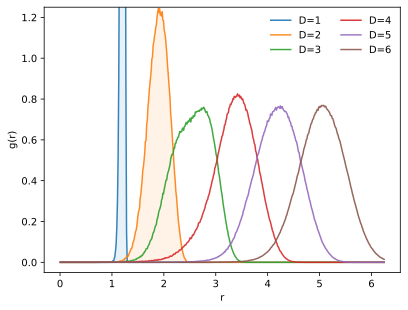

In [3]:
for rs in all_rs[1:]:
    assert np.allclose(rs, all_rs[0])

rs      = all_rs[0]
std_gD  = np.std(np.array(all_gD), axis=0)
mean_gD = np.mean(np.array(all_gD), axis=0)

fig, ax = plt.subplots()

for D in [1, 2, 3, 4, 5, 6]:
    ax.plot(rs/8, mean_gD[D-1], label=f"D={D}", alpha=0.9)
    if D in [1, 2]:
        ax.fill_between(rs/8, 0, mean_gD[D-1], alpha=0.1)

ax.set_xlabel("r")
ax.set_ylabel("g(r)")
ax.set_ylim(-0.05, 1.25)
ax.legend(ncol=2, frameon=False)

plt.show()

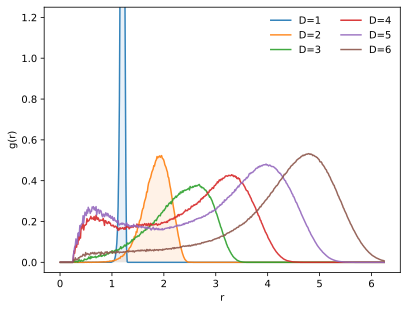

In [ ]:
all_rs = []
all_gD = []
for index in range(1, 101):

    topo = tm.Topology.from_conflink("data/conflink_p20.0.dat", index=-index)
    assert topo.lattice is not None, "Topology must have lattice information."

    rs, gD, _ = run_bond_distance_rdf(
        positions=topo.cartesian_coordinates,
        edges=topo.edges,
        cell_lengths=topo.lattice.lengths,
        cell_angles=topo.lattice.angles,
        dmax=6,
        rmax=50.0,
        dr=0.1,
    )

    all_rs.append(rs)
    all_gD.append(gD)

for rs in all_rs[1:]:
    assert np.allclose(rs, all_rs[0])

rs      = all_rs[0]
std_gD  = np.std(np.array(all_gD), axis=0)
mean_gD = np.mean(np.array(all_gD), axis=0)

fig, ax = plt.subplots()

for D in [1, 2, 3, 4, 5, 6]:
    ax.plot(rs/8, mean_gD[D-1], label=f"D={D}", alpha=0.9)
    if D in [1, 2]:
        ax.fill_between(rs/8, 0, mean_gD[D-1], alpha=0.1)

ax.set_xlabel("r")
ax.set_ylabel("g(r)")
ax.set_ylim(-0.05, 1.25)
ax.legend(ncol=2, frameon=False)

plt.show()

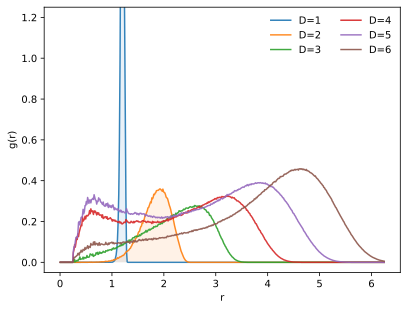

In [ ]:
all_rs = []
all_gD = []
for index in range(1, 101):

    topo = tm.Topology.from_conflink("data/conflink_p32.0.dat", index=-index)
    assert topo.lattice is not None, "Topology must have lattice information."

    rs, gD, _ = run_bond_distance_rdf(
        positions=topo.cartesian_coordinates,
        edges=topo.edges,
        cell_lengths=topo.lattice.lengths,
        cell_angles=topo.lattice.angles,
        dmax=6,
        rmax=50.0,
        dr=0.1,
    )

    all_rs.append(rs)
    all_gD.append(gD)

for rs in all_rs[1:]:
    assert np.allclose(rs, all_rs[0])

rs      = all_rs[0]
std_gD  = np.std(np.array(all_gD), axis=0)
mean_gD = np.mean(np.array(all_gD), axis=0)

fig, ax = plt.subplots()

for D in [1, 2, 3, 4, 5, 6]:
    ax.plot(rs/8, mean_gD[D-1], label=f"D={D}", alpha=0.9)
    if D in [1, 2]:
        ax.fill_between(rs/8, 0, mean_gD[D-1], alpha=0.1)

ax.set_xlabel("r")
ax.set_ylabel("g(r)")
ax.set_ylim(-0.05, 1.25)
ax.legend(ncol=2, frameon=False)

plt.show()

### coiled rings

Coiled rings are cyclic paths in the network whose geometry is strongly 
distorted away from a planar-like conformation. In this sense, coiled rings 
exhibit supercoiling in three dimensions, i.e., the closed path winds around 
itself.

The degree of coiling (and, more generally, self-entanglement of the ring
backbone) is quantified by the writhe of the cyclic path $C_i$,

$$
Wr_i \;=\; \frac{1}{4\pi}\oint_{C_i}\!\!\oint_{C_i}
\frac{\mathbf r_i' - \mathbf r_i}{\left\lVert \mathbf r_i' - \mathbf r_i \right\rVert^{3}}
\cdot \left(d\mathbf r_i' \times d\mathbf r_i\right).
$$

Here, $\mathbf r_i$ and $\mathbf r_i'$ denote two points on the same closed
curve $C_i$, and $d\mathbf r_i$, $d\mathbf r_i'$ are the corresponding
infinitesimal tangent vectors along the curve.

Geometrically, $Wr_i$ measures how many times the closed path loops around
itself in 3D. Approximately planar rings have $Wr_i \approx 0$, while strongly
coiled rings have $|Wr_i|\gtrsim 1$ (with larger $|Wr_i|$ indicating more
pronounced self-winding). When chirality is not of interest, one often reports
$|Wr_i|$, since the sign of $Wr_i$ encodes handedness.


In [6]:
topo = tm.Topology.from_conflink("data/conflink_p2.0.dat")
rings = topo.get_rings(depth=8)
topo

Topology(nodes=1000, edges=3982, has_lattice=True)

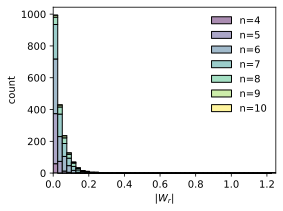

In [7]:
all_writhes = defaultdict(list)
for ring in rings:

    if len(ring) > 10:
        continue

    writhe, _ = ring.writhe_and_acn() # type: ignore
    all_writhes[len(ring)].append(abs(writhe))

bins = np.linspace(0, 1.25, 50)    

fig, ax = tm_ana.plot_writhe_distributions(all_writhes, bins=bins)
ax.set_xlim(0, 1.25)
plt.show()

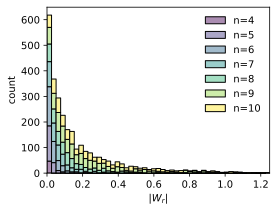

In [8]:
topo = tm.Topology.from_conflink("data/conflink_p20.0.dat")
rings = topo.get_rings(depth=8)

all_writhes = defaultdict(list)
for ring in rings:

    if len(ring) > 10:
        continue

    writhe, _ = ring.writhe_and_acn() # type: ignore
    all_writhes[len(ring)].append(abs(writhe))

fig, ax = tm_ana.plot_writhe_distributions(all_writhes, bins=bins)
ax.set_xlim(0, 1.25)
plt.show()

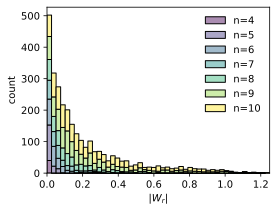

In [9]:
topo = tm.Topology.from_conflink("data/conflink_p32.0.dat")
rings = topo.get_rings(depth=8)

all_writhes = defaultdict(list)
for ring in rings:

    if len(ring) > 10:
        continue

    writhe, _ = ring.writhe_and_acn() # type: ignore
    all_writhes[len(ring)].append(abs(writhe))

fig, ax = tm_ana.plot_writhe_distributions(all_writhes, bins=bins)
ax.set_xlim(0, 1.25)
plt.show()

### linked rings

Linked rings are two (or more) disjoint rings (i.e., rings that do not share any
vertices) which are entangled with one another in such a way that they cannot 
be unlinked without at least one bond being broken.

In [10]:
from topo_metrics import Node
from topo_metrics.io.lmp import write_rings_lammps_full
from topo_metrics.knots import linking_number_method_1a
from topo_metrics.ring_geometry import RingGeometry


def circle_xy(n=400, r=1.0, center=(0.0, 0.0, 0.0), z=0.0) -> RingGeometry:
    """ circle in plane z = center[2] + z. """

    t = np.linspace(0.0, 2.0 * math.pi, n, endpoint=False)
    x = center[0] + r * np.cos(t)
    y = center[1] + r * np.sin(t)
    zz = np.full_like(t, center[2] + z)

    coords = np.column_stack([x, y, zz])

    return RingGeometry(tuple(
        Node(node_id=node_id, cart_coord=pos) 
        for node_id,pos in enumerate(coords, start=1)
    ))


def circle_xz(n=400, r=1.0, center=(1.0, 0.0, 0.0)):
    """ circle in plane y = center[1] """

    t = np.linspace(0.0, 2.0 * math.pi, n, endpoint=False)
    x = center[0] + r * np.cos(t)
    y = np.full_like(t, center[1])
    z = center[2] + r * np.sin(t)

    coords = np.column_stack([x, y, z])

    return RingGeometry(tuple(
        Node(node_id=node_id, cart_coord=pos) 
        for node_id,pos in enumerate(coords, start=1)
    ))

#### Hopf link

The Hopf link is the simplest nontrivial link with two components. It consists 
of two closed loops linked exactly once, meaning the two components cannot be
separated without cutting. In an oriented setting, its linking number is
$\mathrm{Lk} = \pm 1$ (the sign depends on the chosen orientations). The Hopf
link is named after Heinz Hopf.

![Hopf link](figures/hopf.png)

In [ ]:
ring1 = circle_xy(n=400, r=1.0)
ring2 = circle_xz(n=400, r=1.0, center=(1,0,0))

write_rings_lammps_full(
    rings=[ring1, ring2],
    filepath="configs/hopf.data",
    cell=np.diag([10.0, 10.0, 10.0]),
    pbc=True,
)

lk = linking_number_method_1a(ring1.positions, ring2.positions)
print(f"Lk (float): {lk:.0f}")

Lk (float): -1


To illustrate how the linking number depends on orientation, we compute it for 
the original ordering of one ring and again after reversing that ring’s vertex 
order.


In [12]:
lk1 = linking_number_method_1a(ring1.positions, ring2.positions)
lk2 = linking_number_method_1a(ring1.positions, ring2.positions[::-1])

print(
    "Lk forward:", int(round(lk1)), 
    "\nLk reversed:", int(round(lk2))
)

Lk forward: -1 
Lk reversed: 1


As a sanity check, we place the second ring far from the first (so the two 
components are unlinked) and verify that the computed linking number is zero.

![Unlinked rings](figures/separate.png)

In [13]:
ring2_far = circle_xz(n=400, r=1.0, center=(3,0,0))

write_rings_lammps_full(
    rings=[ring1, ring2_far],
    filepath="configs/separate.data",
    cell=np.diag([10.0, 10.0, 10.0]),
    pbc=True,
)

lk = linking_number_method_1a(ring1.positions, ring2_far.positions)
print("Lk:", int(round(lk)))

Lk: 0


Now we apply the same ring-topology workflow—ring extraction from the bonded 
tetrahedral network followed by pairwise linking-number evaluation—to the vHDA 
tetrahedral network models explored earlier. In particular, we focus on 
comparing the lowest and highest state points. This analysis is closely 
motivated by the framework of Neophytou *et al.* (PNAS **121**, e2406890121), 
who argue that densification in tetrahedral network liquids is driven by the 
emergence of **linked rings** and proceeds via a hierarchy of topological 
transitions.

In [14]:
topo_p2 = tm.Topology.from_conflink("data/conflink_p2.0.dat")
rings_p2 = topo_p2.get_rings(depth=8)

assert topo_p2.lattice is not None, "Topology must have lattice information."

n_rings = len(rings_p2)
n_pairs = n_rings * (n_rings - 1) // 2

linked_rings_p2 = []
for ringA, ringB in tqdm(combinations(rings_p2, 2), total=n_pairs):
    lk, img = ringA.linking_number(ringB, cell=topo_p2.lattice.matrix)
    lk_rounded = np.round(abs(lk), 8)
    linked_rings_p2.append((ringA, ringB, lk, img))

100%|██████████| 1865346/1865346 [06:48<00:00, 4562.66it/s]


In [15]:
topo_p32 = tm.Topology.from_conflink("data/conflink_p32.0.dat")
rings_p32 = topo_p32.get_rings(depth=8)

assert topo_p32.lattice is not None, "Topology must have lattice information."

n_rings = len(rings_p32)
n_pairs = n_rings * (n_rings - 1) // 2

linked_rings_p32 = []
for ringA, ringB in tqdm(combinations(rings_p32, 2), total=n_pairs):
    lk, img = ringA.linking_number(ringB, cell=topo_p32.lattice.matrix)
    lk_rounded = np.round(abs(lk), 8)
    linked_rings_p32.append((ringA, ringB, lk, img))

100%|██████████| 13889085/13889085 [1:48:27<00:00, 2134.35it/s]  


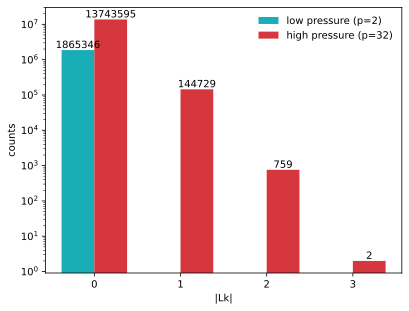

In [ ]:
def lk_int_counts(linked_rings) -> tuple[np.ndarray, np.ndarray]:
    """ Get counts of integer linking numbers from linked_rings list. """

    lk = np.array([abs(x[2]) for x in linked_rings], dtype=float)
    lk_i = np.rint(lk).astype(int)
    vals, counts = np.unique(lk_i, return_counts=True)
    return vals, counts

vals_p2, counts_p2 = lk_int_counts(linked_rings_p2)
vals_p32, counts_p32 = lk_int_counts(linked_rings_p32)

vals = np.union1d(vals_p2, vals_p32)
c2 = np.zeros_like(vals, dtype=int)
c32 = np.zeros_like(vals, dtype=int)

map_p2 = dict(zip(vals_p2, counts_p2))
map_p32 = dict(zip(vals_p32, counts_p32))

for i, v in enumerate(vals):
    c2[i] = map_p2.get(v, 0)
    c32[i] = map_p32.get(v, 0)

fig, ax = plt.subplots()

w = 0.38
x = np.arange(len(vals))

ax.bar(
    x - w/2, c2, 
    width=w,
    color="#00A6AF",
    alpha=0.9,
    label="low pressure (p=2)"
)

ax.bar(
    x + w/2, c32,
    width=w,
    color="#D22128",
    alpha=0.9,
    label="high pressure (p=32)"
)

ax.set_xticks(x)
ax.set_xticklabels(vals)
ax.set_xlabel("|Lk|")
ax.set_yscale("log")
ax.set_ylabel("counts")
ax.legend(frameon=False)

for xi, c in zip(x - w/2, c2):
    if c > 0:
        ax.text(xi, c, f"{c}", ha="center", va="bottom")

for xi, c in zip(x + w/2, c32):
    if c > 0:
        ax.text(xi, c, f"{c}", ha="center", va="bottom")

plt.show()

In [ ]:
def random_linking_example(
    linked_rings: Iterable[tuple[Any, Any, float, Any]],
    lk_int: int,
    *,
    tol: float = 1e-6,
    rng: random.Random | None = None,
) -> tuple[Any, Any, float, Any]:
    """
    Return a random (ring1, ring2, lk_val, img_val) whose lk_val is the 
    specified integer lk_int.
    """

    if rng is None:
        rng = random.Random()

    matches = []
    target = float(lk_int)

    for ring1, ring2, lk_val, img_val in linked_rings:
        if abs(float(lk_val) - target) <= tol:
            matches.append((ring1, ring2, lk_val, img_val))

    if not matches:
        raise ValueError(
            f"No examples found with linking number {lk_int} within tol={tol}"
        )

    return rng.choice(matches)

In [18]:
assert topo_p32.lattice is not None, "Topology must have lattice information."

for lk_target in (1, 2, 3):

    ring1, ring2, lk_val, img_val = random_linking_example(
        linked_rings=linked_rings_p32,
        lk_int=lk_target
    )

    packed = write_rings_lammps_full(
        rings=[ring1, ring2],
        filepath=f"configs/lk_{lk_target}.data",
        cell=topo_p32.lattice.matrix,
        pbc=True,
        images=np.array([[0, 0, 0], img_val], dtype=int),
    )

![Entangled rings](figures/linking-numbers.png)